In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
import scienceplots
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [30] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81]])

## Optimization Model 

In [5]:
ks_model = pyepo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-09


In [6]:
# solve
ks_model.setObj([i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Obj: 265.0
40
43
44
45
46
47


In [7]:
# relax
ks_model_rel = ks_model.relax()

In [8]:
# solve
ks_model_rel.setObj([i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9225932025752352, 0.0, 0.0, 1.0, 0.6333283425662526, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
Obj: 281.10241054050005
37
40
41
43
45
46
47


## Data Loader 

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [10]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [11]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 313.43it/s]


In [12]:
# get training data set for relaxation
ks_dataset_train_rel = pyepo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 917.29it/s]


In [13]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 272.44it/s]


In [14]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [15]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [16]:
x.shape

torch.Size([32, 5])

In [17]:
c.shape

torch.Size([32, 48])

In [18]:
w.shape

torch.Size([32, 48])

In [19]:
z.shape

torch.Size([32, 1])

## Linear Regression from PyTorch

In [20]:
from torch import nn

In [21]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [22]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [23]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [24]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(ks_model, processes=4, solve_ratio=0.1, dataset=ks_dataset_train)

Num of cores: 4


In [25]:
# train model
num_epochs = 200
reg.train()
loss_log = []
regret_log = []
unambregret_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        regret = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        regret_log.append(regret)
        # unambiguous regret 
        unambregret = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        unambregret_log.append(unambregret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), regret*100, unambregret*100))

Epoch   0, Loss:  76.7699, Regret: 41.7439%, Unambiguous Regret: 41.7439%
Epoch   5, Loss:  16.9382, Regret: 30.2261%, Unambiguous Regret: 30.2261%
Epoch  10, Loss:  24.3174, Regret: 22.3993%, Unambiguous Regret: 22.3993%
Epoch  15, Loss:  27.8423, Regret: 17.6677%, Unambiguous Regret: 17.6677%
Epoch  20, Loss:  16.2587, Regret: 15.4535%, Unambiguous Regret: 15.4535%
Epoch  25, Loss:  16.5307, Regret: 14.0695%, Unambiguous Regret: 14.0695%
Epoch  30, Loss:  49.3358, Regret: 13.2331%, Unambiguous Regret: 13.2331%
Epoch  35, Loss:  61.7735, Regret: 12.8028%, Unambiguous Regret: 12.8028%
Epoch  40, Loss:  37.4102, Regret: 12.3240%, Unambiguous Regret: 12.3240%
Epoch  45, Loss:  26.4563, Regret: 12.0048%, Unambiguous Regret: 12.0048%
Epoch  50, Loss:  29.6884, Regret: 11.7239%, Unambiguous Regret: 11.7239%
Epoch  55, Loss:   7.1503, Regret: 11.5825%, Unambiguous Regret: 11.5825%
Epoch  60, Loss:  13.7166, Regret: 11.6633%, Unambiguous Regret: 11.6633%
Epoch  65, Loss:  24.0564, Regret: 11.

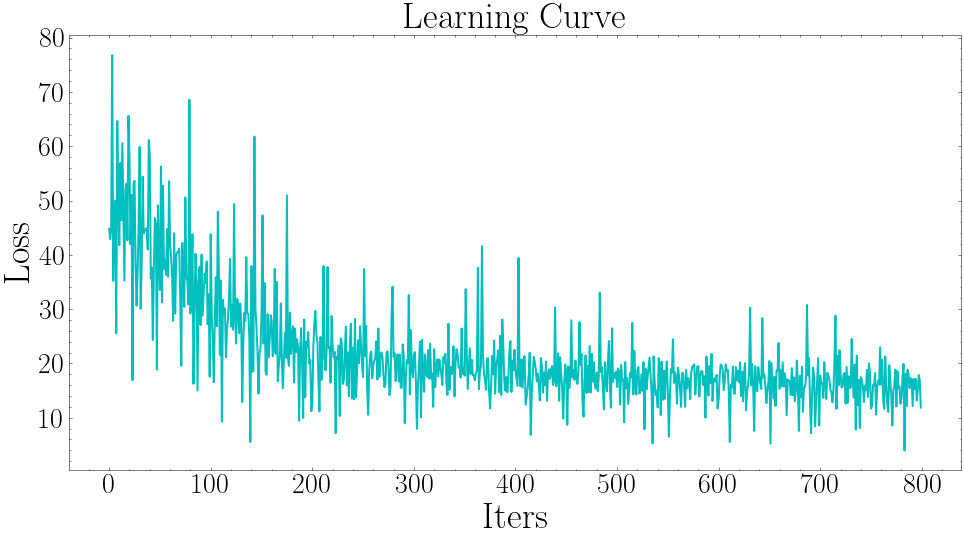

In [26]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

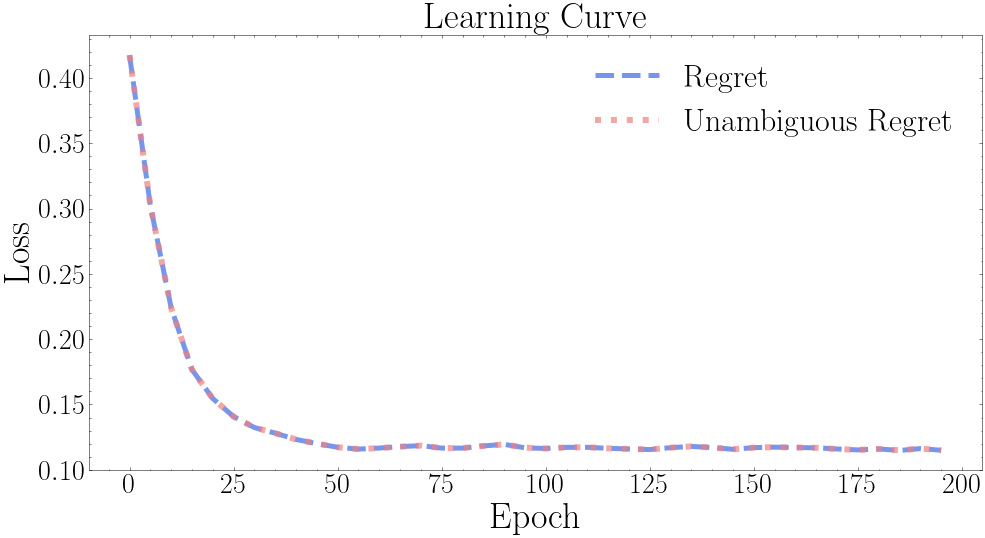

In [27]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), unambregret_log, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [28]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 11.49%
Normalized Unambiguous Regret: 11.49%


In [29]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(-cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(-z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(-zpj))
        print()
    break

Sample 0:
    True cost: -2.00, -4.00, -1.00, -1.00, -2.00, -1.00, -2.00, -1.00, -1.00, -2.00, -5.00, -1.00, -1.00, -5.00, -3.00, -2.00, -1.00, -2.00, -3.00, -3.00, -1.00, -1.00, -1.00, -1.00, -3.00, -3.00, -2.00, -2.00, -1.00, -2.00, -2.00, -2.00, -3.00, -1.00, -4.00, -2.00, -1.00, -3.00, -4.00, -1.00, -2.00, -4.00, -1.00, -2.00, -3.00, -1.00, -5.00, -2.00
    Pred cost: 0.93, -3.62, 2.20, 2.19, 1.53, 3.61, -0.88, 0.28, 1.04, 1.28, -3.91, -0.51, 0.80, -4.21, -2.40, 2.07, -1.13, 0.84, -2.51, -0.40, 0.51, 3.21, 1.49, 1.98, -2.74, -2.82, -1.24, -2.88, 1.27, -0.35, 1.60, 1.40, -3.03, 1.21, -2.61, -3.00, 0.01, -1.44, -1.88, 2.12, -0.75, -3.68, 0.64, -2.05, -1.04, 0.21, -4.03, 0.64
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: -27.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

## Black-Box

In [30]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [31]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [32]:
# set loss
dbb = pyepo.func.blackboxOpt(ks_model, lambd=20, processes=4, solve_ratio=0.1, dataset=ks_dataset_train)
criterion = nn.L1Loss()

Num of cores: 4


In [33]:
# train model
num_epochs = 200
reg.train()
loss_log = []
regret_log = []
unambregret_log = []
for epoch in range(num_epochs):
    for para in reg.parameters():
        #print(para.data[:4,0])
        break
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = dbb(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(abs_grad)
        loss_log.append(loss.item())
    if epoch % 5 == 0:
        # true regret
        regret = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        regret_log.append(regret)
        # unambiguous regret 
        unambregret = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        unambregret_log.append(unambregret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch, loss.item(), regret*100, unambregret*100))

Epoch   0, Loss:  28.5000, Regret: 47.8574%, Unambiguous Regret: 47.8574%
Epoch   5, Loss:  19.0000, Regret: 35.1577%, Unambiguous Regret: 35.1577%
Epoch  10, Loss:  17.7500, Regret: 31.0059%, Unambiguous Regret: 31.0059%
Epoch  15, Loss:  19.7500, Regret: 26.2400%, Unambiguous Regret: 26.2400%
Epoch  20, Loss:  15.5000, Regret: 24.0722%, Unambiguous Regret: 24.0722%
Epoch  25, Loss:  25.0000, Regret: 22.2478%, Unambiguous Regret: 22.2478%
Epoch  30, Loss:  16.7500, Regret: 21.4053%, Unambiguous Regret: 21.4053%
Epoch  35, Loss:   8.7500, Regret: 20.4154%, Unambiguous Regret: 20.4154%
Epoch  40, Loss:  20.2500, Regret: 19.8214%, Unambiguous Regret: 19.8214%
Epoch  45, Loss:   7.2500, Regret: 19.4335%, Unambiguous Regret: 19.4335%
Epoch  50, Loss:  11.0000, Regret: 18.9587%, Unambiguous Regret: 18.9587%
Epoch  55, Loss:  16.2500, Regret: 18.7082%, Unambiguous Regret: 18.7082%
Epoch  60, Loss:   4.5000, Regret: 18.7648%, Unambiguous Regret: 18.7648%
Epoch  65, Loss:  10.7500, Regret: 18.

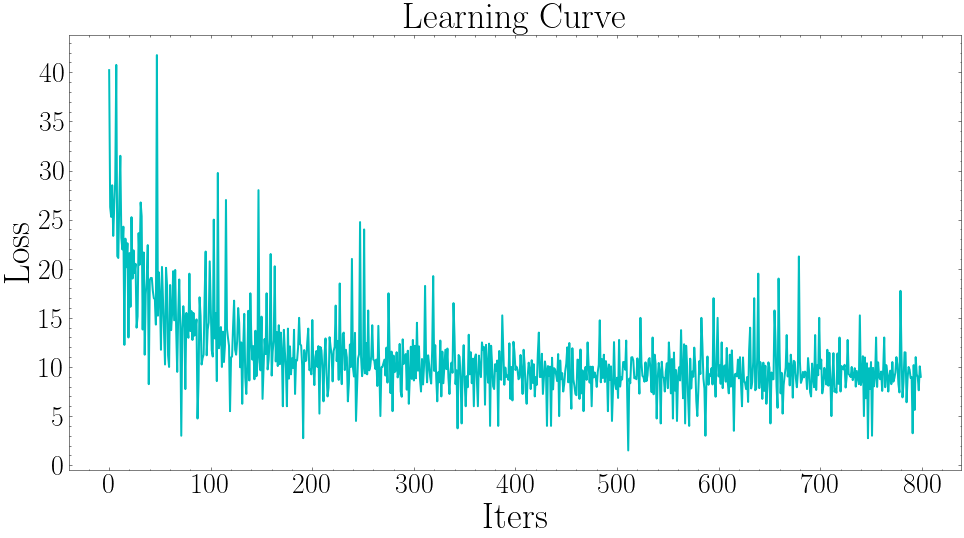

In [34]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28) 
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

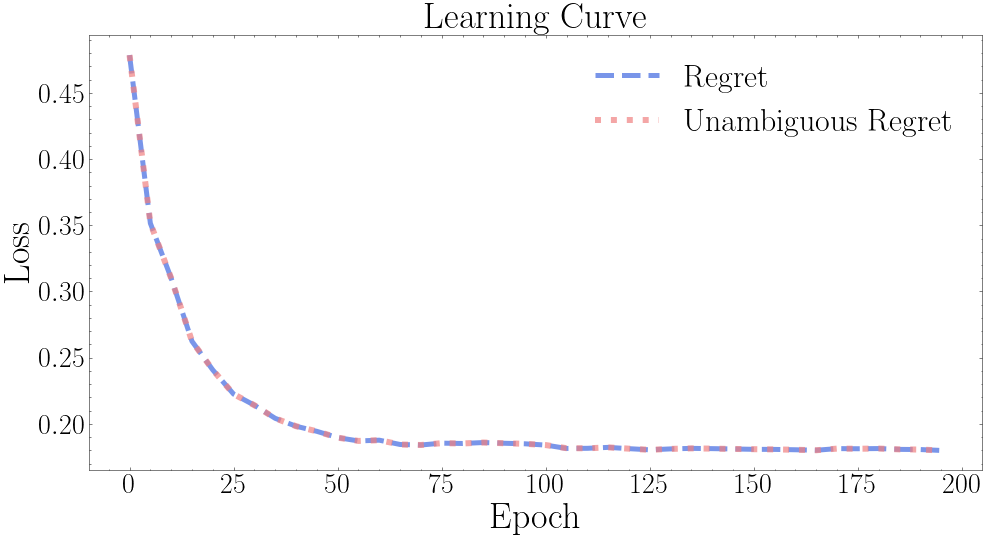

In [35]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), unambregret_log, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [36]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 17.88%
Normalized Unambiguous Regret: 17.88%


In [37]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: -4.56, 19.75, -7.71, -1.71, -0.81, -2.62, 1.15, -1.27, -0.88, -1.29, 17.68, -0.18, -2.34, 20.09, 4.32, -1.46, -0.12, -2.71, 16.94, 5.37, -2.53, -1.45, -0.67, -14.33, 12.25, 8.90, 3.82, 15.18, -2.65, 0.85, -4.21, -1.96, 14.38, -0.84, 9.83, 16.71, -0.31, 3.26, 1.05, -1.70, 3.65, 7.79, -1.22, -0.79, -0.50, -3.27, 16.36, -1.60
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,